In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import import_ipynb
import sklearn
import tslearn
from concurrent.futures import ProcessPoolExecutor
import os
import pickle
import time
from sklearn.metrics import silhouette_samples
from tslearn.metrics import cdist_soft_dtw_normalized

/usr/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import Prepare_time_series as pts

importing Jupyter notebook from Prepare time series.ipynb


In [3]:
np.set_printoptions(suppress=True, precision=5)

In [4]:
szeregi=np.array(pts.przygotujSzeregiCzasowe(50,256))
szeregi=szeregi.reshape(*szeregi.shape,1)

KatalogPickli="Pickle"

In [84]:
with open(os.path.join(KatalogPickli, "1620282175.0956235-modele"), "rb") as plik:
    modele=pickle.load(plik)
with open(os.path.join(KatalogPickli, "borrelia-odleglosciMiedzySzeregami-normalized-softdtw"), "rb") as plik:
    odl=pickle.load(plik)

In [85]:
wybModel=modele[4]
wybModel

TimeSeriesKMeans(metric='softdtw', n_clusters=7)

In [22]:
etykiety=wybModel.predict(szeregi)

In [86]:
print(np.unique(etykiety, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6]), array([185, 279, 209, 131,  88, 195, 266]))


In [87]:
indeksySS=silhouette_samples(odl, etykiety, metric="precomputed")

In [89]:
indeksyDlaGrup=[]
silScoreDlaGrup=[]
for i in range(wybModel.n_clusters):
    indeksyDlaGrup.append(indeksySS[etykiety==i])
    silScoreDlaGrup.append(np.mean(indeksySS[etykiety==i]))

[0.15167306122680072, 0.22896820417174063, 0.22852963734154202, 0.13741665978748485, 0.0925031016784474, 0.27752427568638116, 0.28460835695735826]


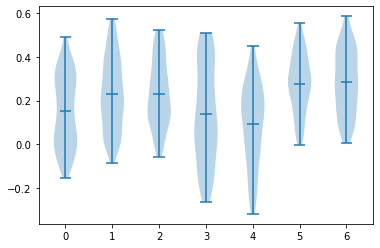

In [90]:
print(silScoreDlaGrup)
plt.violinplot(indeksyDlaGrup, positions=np.arange(wybModel.n_clusters), showmeans=True, showmedians=False)
plt.show()

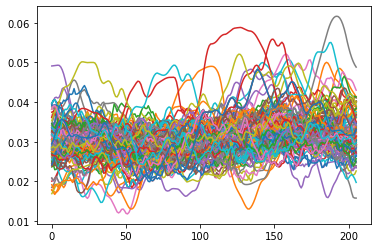

In [15]:
for i in szeregi[etykiety==3]:
    plt.plot(i)

In [69]:
def wskaznikGestosci(odl, etykiety, liczbaSasiadow=5):
    wyniki=[]
    for k in range(7):
        sasiedziMoi=odl[etykiety==k][:,etykiety==k]
        sasiedziObcy=odl[etykiety==k][:,etykiety!=k]
        argPartMoi=np.argpartition(sasiedziMoi,liczbaSasiadow)[:,:liczbaSasiadow]
        argPartObcy=np.argpartition(sasiedziObcy,liczbaSasiadow)[:,:liczbaSasiadow]
        najblizszeOdlMoi=sasiedziMoi[np.arange(sasiedziMoi.shape[0]).repeat(liczbaSasiadow),argPartMoi.ravel()]
        najblizszeOdlObcy=sasiedziObcy[np.arange(sasiedziObcy.shape[0]).repeat(liczbaSasiadow),argPartObcy.ravel()]
        najblizszeOdlMoi=np.mean(najblizszeOdlMoi.reshape((-1,liczbaSasiadow)),axis=-1)
        najblizszeOdlObcy=np.mean(najblizszeOdlObcy.reshape((-1,liczbaSasiadow)), axis=1)
        silScore=(najblizszeOdlObcy-najblizszeOdlMoi)/np.maximum(najblizszeOdlMoi, najblizszeOdlObcy)
        wyniki.append(silScore)
    return wyniki

[0.57216 0.7126  0.56829 0.61768 0.56862 0.55155 0.62027]
[0.45319 0.62189 0.4542  0.5115  0.432   0.44482 0.52873]
[0.3387  0.51858 0.35721 0.42361 0.31094 0.35394 0.43741]
[0.25226 0.43698 0.2867  0.34502 0.21918 0.28954 0.36458]


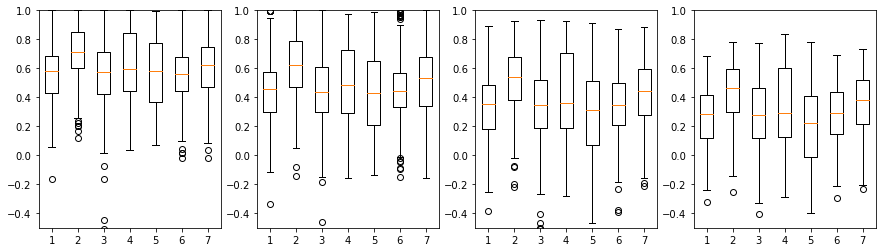

In [91]:
plt.gcf().set_size_inches((15,4))
i=0
for s in [3,5,9,15]:
    i+=1
    mojeSilScore=wskaznikGestosci(odl, etykiety,s)
    mojSilScoreGroup=np.array([L.mean() for L in mojeSilScore])
    print(mojSilScoreGroup)

    plt.subplot(1,4,i)
    plt.ylim((-0.5, 1))
    plt.boxplot(mojeSilScore)
    #plt.violinplot(mojeSilScore, positions=np.arange(wybModel.n_clusters), showmeans=True, showmedians=False)
plt.show()

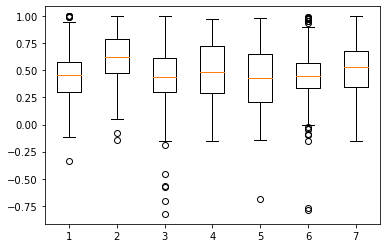

In [80]:
plt.boxplot(mojeSilScore)
plt.show()

In [81]:
print([L.mean() for L in mojeSilScore])

[0.4531934321387857, 0.6218884628646083, 0.4542005155422179, 0.5115004843132422, 0.4319995234669559, 0.4448156893333717, 0.5287341132232419]


In [32]:
from sklearn.manifold import TSNE, Isomap, MDS

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 1353
[t-SNE] Computed conditional probabilities for sample 1353 / 1353
[t-SNE] Mean sigma: 0.000004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.424242
[t-SNE] KL divergence after 1200 iterations: 1.559655


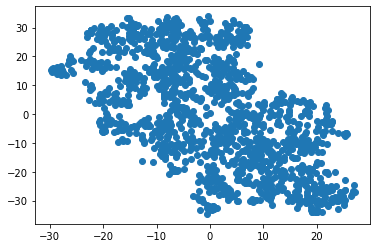

In [20]:
tsne=TSNE(metric="precomputed", method="exact", verbose=1, square_distances="legacy", n_iter=2000)
tsneOdl=tsne.fit_transform(odl)

plt.scatter(tsneOdl[:,0], tsneOdl[:,1])

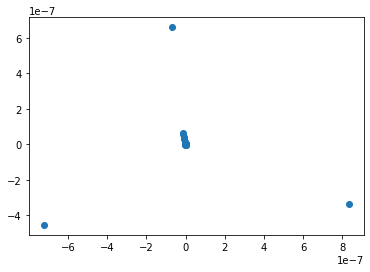

In [23]:
isomap=Isomap(metric="precomputed", n_neighbors=9)
isomapOdl=isomap.fit_transform(odl)

plt.scatter(isomapOdl[:,0], isomapOdl[:,1])

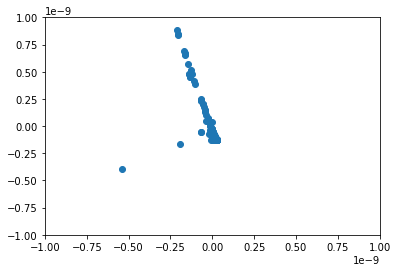

In [31]:
plt.ylim((-1e-9,1e-9))
plt.xlim((-1e-9,1e-9))
plt.scatter(isomapOdl[:,0], isomapOdl[:,1])

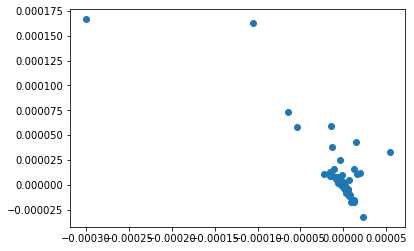

In [33]:
mds=MDS(dissimilarity="precomputed")
mdsOdl=mds.fit_transform(odl)
plt.scatter(mdsOdl[:,0], mdsOdl[:,1])

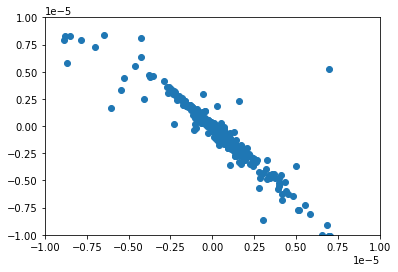

In [36]:
Ylim=0.00001
Xlim=0.00001
plt.ylim((-Ylim,Ylim))
plt.xlim((-Xlim,Xlim))
plt.scatter(mdsOdl[:,0], mdsOdl[:,1])

breaking at iteration 2 with stress 41645.311784606456
breaking at iteration 2 with stress 41885.078261654395
breaking at iteration 2 with stress 41870.56701768359
breaking at iteration 2 with stress 41905.15251824505


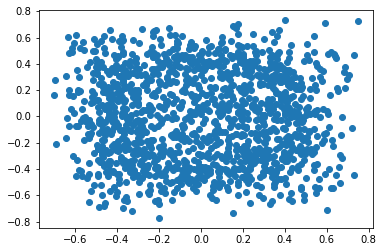

In [39]:
mds=MDS(dissimilarity="precomputed", metric=False, eps=1e-9, max_iter=3000, verbose=1)
mdsOdl=mds.fit_transform(odl)
plt.scatter(mdsOdl[:,0], mdsOdl[:,1])

In [22]:
%%time
model=TimeSeriesKMeans(n_clusters=7,metric="softdtw", max_iter=200, verbose=1)
model.fit(szeregi)

128261.297 --> 128262.635 --> 128262.778 --> 128262.828 --> 128262.864 --> 128262.895 --> 128262.916 --> 128262.931 --> 128262.947 --> 128262.954 --> 128262.959 --> 128262.963 --> 128262.965 --> 128262.967 --> 128262.970 --> 128262.972 --> 128262.975 --> 128262.977 --> 128262.978 --> 128262.980 --> 128262.981 --> 128262.983 --> 128262.985 --> 128262.986 --> 128262.987 --> 128262.989 --> 128262.990 --> 128262.993 --> 128262.995 --> 128262.996 --> 128262.997 --> 128262.998 --> 128262.999 --> 128263.000 --> 128263.001 --> 128263.001 --> 128263.001 --> 128263.001 --> 128263.001 --> 
CPU times: user 35min 44s, sys: 1.6 s, total: 35min 45s
Wall time: 35min 50s


TimeSeriesKMeans(max_iter=200, metric='softdtw', n_clusters=7, verbose=1)

In [ ]:
etykietyModel=model.predict(szeregi)

In [26]:
silhouette_score(odl, etykiety,metric="precomputed")

0.21852864123031893

In [27]:
%%time
model=TimeSeriesKMeans(n_clusters=7,metric="softdtw", max_iter_barycenter=200, verbose=1)
model.fit(szeregi)

128261.263 --> 128262.868 --> 128262.924 --> 128262.952 --> 128262.968 --> 128262.980 --> 128262.992 --> 128262.996 --> 128263.000 --> 128263.003 --> 128263.006 --> 128263.009 --> 128263.011 --> 128263.011 --> 128263.012 --> 128263.013 --> 128263.013 --> 128263.014 --> 128263.014 --> 128263.014 --> 128263.015 --> 128263.015 --> 128263.015 --> 128263.016 --> 128263.016 --> 128263.016 --> 128263.016 --> 
CPU times: user 23min 50s, sys: 199 ms, total: 23min 50s
Wall time: 23min 52s


TimeSeriesKMeans(max_iter_barycenter=200, metric='softdtw', n_clusters=7,
                 verbose=1)

In [28]:
etykietyModel=model.predict(szeregi)

In [29]:
silhouette_score(odl, etykietyModel,metric="precomputed")

0.2144470071672487

In [32]:
with open(os.path.join(KatalogPickli, str(time.time())+"-model-200iterbary-7cluster"), "wb") as plik:
    pickle.dump(model,plik)

# Silhouete na macierzy nieznormalizowanej

In [94]:
with open(os.path.join(KatalogPickli, "borrelia-odleglosciMiedzySzeregami-softdtw"), "rb") as plik:
    odl=pickle.load(plik)

In [95]:
def normalizujPrzezPrzekatna(odl):
    return odl-np.diag(odl)

def silhoueteNieznormalizowanej(odl, etykiety, liczbaGrup=7):
    wyniki=[]
    odl=normalizujPrzezPrzekatna(odl)
    for k in range(7):
        sasiedziMoi=odl[etykiety==k][:,etykiety==k]
        sasiedziObcy=odl[etykiety==k][:,etykiety!=k]
        grupaNajblizszegoObcego=etykiety[np.argmin(sasiedziObcy,axis=1)]
        podobienstwoMoi=np.mean(sasiedziMoi,axis=1)
        odlegloscOdBliskichObcych=np.ma.array(odl[etykiety==k],mask=np.logical_not(etykiety.reshape((1,-1))==grupaNajblizszegoObcego.reshape((-1,1))))
        podobienstwoObcy=np.array(np.ma.mean(odlegloscOdBliskichObcych,axis=1))
        silScore=(podobienstwoObcy-podobienstwoMoi)/np.maximum(abs(podobienstwoMoi), abs(podobienstwoObcy))
        wyniki.append(silScore)
    return wyniki

[0.34241 0.35869 0.34205 0.39859 0.39631 0.40602 0.37404]


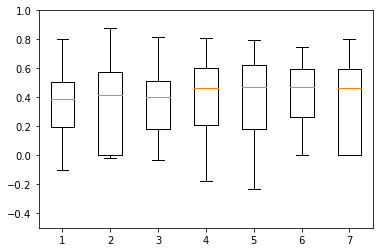

In [96]:
mojeSilScore=silhoueteNieznormalizowanej(odl, etykiety)
mojSilScoreGroup=np.array([L.mean() for L in mojeSilScore])
print(mojSilScoreGroup)

plt.ylim((-0.5, 1))
plt.boxplot(mojeSilScore)
plt.show()

#Normalny silheuete indeks dla grup[0.1516, 0.2289, 0.2285, 0.1374, 0.0925, 0.2775, 0.2846]